In [ ]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np, pickle
import math, sys, os, glob, h5py, json
from astropy import units as u
from sklearn.neighbors import KernelDensity

import pint
from pint import toa
from pint import models
from pint.residuals import Residuals
from pint.simulation import make_fake_toas_fromMJDs
pint.logging.setup(sink=sys.stderr, level="WARNING", usecolors=True)

import pta_replicator
from pta_replicator import simulate
from pta_replicator import white_noise

WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/enterprise/signals/utils.py:13 UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
libstempo not installed. PINT or libstempo are required to use par and tim files.


WARNING  (pint.models.noise_model       ): Log-spaced parameters are ignored because logmode, nlog, and f_min ALL neeed to be setUse: logmode > 0 and nlog > 0 and f_min > 0.
WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/noise_model.py:216 UserWarning: EQUAD maskParameter(EQUAD2 -f Rcvr1_2_GASP 0.05873021316047649 (us) frozen=True) has no TOAs
WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/noise_model.py:216 UserWarning: EQUAD maskParameter(EQUAD3 -f Rcvr1_2_GUPPI 0.03650421674163529 (us) frozen=True) has no TOAs
WARNING  (pint.logging                  ): /opt/homebrew/Caskroom/mambaforge/base/envs/sarahspta/lib/python3.12/site-packages/pint/models/noise_model.py:216 UserWarning: EQUAD maskParameter(EQUAD4 -f Rcvr1_2_VEGAS 0.020213788954476893 (us) frozen=True) has no TOAs
WARNING  (pint.logging            

In [2]:

# myparfile = datadir + 'parfiles/J1909-3744_PINT_20250319.nb.par'
# mytimfile = datadir + 'timfiles/J1909-3744_PINT_20250411.nb.tim'

#my paths'
mypardir = '/Users/ashokan/osu/sarahspta/ng20/results/'
mytimdir = '/Users/ashokan/osu/sarahspta/NG20_prelim_v1p0_excised_toas/'
myparfile = mypardir + 'J1909-3744_PINT_20250319.nb.par'
mytimfile = mytimdir + 'J1909-3744_PINT_20250411.nb.tim'

# myparfile = mypardir + 'J1713+0747_PINT_20250429.nb.par'
# mytimfile = mytimdir + 'J1713+0747_PINT_20250411.nb.tim'

psr = simulate.load_pulsar(myparfile, mytimfile, ephem='DE440')

In [3]:
# remove red noise from the model (we will add it back later)
if 'PLRedNoise' in psr.model.components.keys():
    psr.model.remove_component('PLRedNoise')
    
psr.generate_daily_avg_toas(ideal=True)

Pulsar J1909-3744 has 47558 TOAs observed with 7 systems...
Filtering out 6988 TOAs with flag 3GHz_YUPPI observed with vla...
Filtering out 809 TOAs with flag Rcvr1_2_GASP observed with gbt...
Filtering out 20554 TOAs with flag Rcvr1_2_GUPPI observed with gbt...
Filtering out 5730 TOAs with flag Rcvr1_2_VEGAS observed with gbt...
Filtering out 869 TOAs with flag Rcvr_800_GASP observed with gbt...
Filtering out 9520 TOAs with flag Rcvr_800_GUPPI observed with gbt...
Filtering out 3088 TOAs with flag Rcvr_800_VEGAS observed with gbt...
Pulsar J1909-3744 now has 758 daily averaged TOAs


In [4]:
def get_current_flags(flags):
    
    current_backends = ['CHIME', 'YUPPI', 'VEGAS']
    current_flags = []
    
    for f in flags:
        if np.any([c in f for c in current_backends]):
            current_flags.append(f)
    
    return current_flags

def get_cadence(toas, flag, dt=365):
    
    obs = toas[toas['f'] == f].get_mjds().to(u.d).value
    
    last_obs = max(obs)
    nobs = len(np.where(obs >= max(obs) - 365)[0])
    
    return nobs

In [5]:
def get_errors(psr, flag, numobs):

    log10_errs = np.log10(psr.toas[psr.toas['f'] == flag].get_errors().to(u.s).value)
    
    # fit KDE to distribution of the log10_errs
    # only fit to the distribution up to the 95% upper limit to avoid drawing extremely large errors
    log10_err_distr = log10_errs[log10_errs < np.percentile(log10_errs, 95)]
    mykde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(log10_err_distr.reshape((log10_err_distr.size, 1)))
    errs = 10**mykde.sample(numobs).reshape(numobs)
    
    return errs

def make_new_toas(psr, flag, cadence, end_mjd):
    
    if 'VEGAS' in flag:
        obs = 'gbt'
    elif 'CHIME' in flag:
        obs = 'chime'
    elif 'YUPPI' in flag:
        obs = 'vla'
    
    last_obs = max(psr.toas[psr.toas['f'] == flag].get_mjds().to(u.d).value)
    
    Tspan = end_mjd - last_obs
    nobs = int(Tspan/365.24*cadence)
    delta_t = 365.24/cadence

    start_mjd = last_obs + delta_t

    mjds = np.arange(start_mjd, end_mjd, delta_t)

    errs = get_errors(psr, flag, nobs)

    return toa.get_TOAs_array(mjds, obs=obs, flags={'f': flag}, model=None, 
                              errors=errs*1e6, planets=True, ephem='DE440')

In [6]:
end_mjd = 61587

flags = list(np.unique(psr.toas['f']))
current_flags = get_current_flags(flags)

if len(current_flags) < 1:
    print('This pulsar is not currently being observed!')

else:
    for f in current_flags:

        print('Making new observations with {0}...'.format(f))
        cadence = get_cadence(psr.toas, f)
        
        if cadence == 0:
            print('This pulsar is not currently being observed with {0}.'.format(f))
            
        else:
            new_toas = make_new_toas(psr, f, cadence, end_mjd)

            # make sure the new TOAs are compatible with the old ones
            if psr.toas.obliquity is not None:
                new_toas.obliquity = psr.toas.obliquity
                new_toas.update_all_times()
    
            if 'fe' in psr.toas.table.keys():
                new_toas.table.add_column([None for _ in range(len(new_toas))], name='fe')
        
            if 'f' in psr.toas.table.keys():
                new_toas.table.add_column([f for _ in range(len(new_toas))], name='f')
    
            psr.toas.merge(new_toas)

Making new observations with 3GHz_YUPPI...
Making new observations with Rcvr1_2_VEGAS...
Making new observations with Rcvr_800_VEGAS...


In [26]:
def make_residual_plot(psr, save=False, savefilename=None, simdir='/Users/ashokan/osu/sarahspta/pta_replicator/examples/plots/'):

    # switch to rainbow colormap grouped by telescopes
    colors = {
                "CHIME": "#FFA733", 
                "327_ASP": "#BE0119",
                "327_PUPPI": "#BE0119",
                "430_ASP": "#FD9927",
                "430_PUPPI": "#FD9927",
                "L-wide_ASP": "#BDB6F6",
                "L-wide_PUPPI": "#BDB6F6",
                "Rcvr1_2_GASP": "#79A3E2",
                "Rcvr1_2_GUPPI": "#79A3E2",
                "Rcvr1_2_VEGAS": "#79A3E2",
                "Rcvr_800_GASP": "#8DD883",
                "Rcvr_800_GUPPI": "#8DD883",
                "Rcvr_800_VEGAS": "#8DD883",
                "S-wide_ASP": "#C4457A",
                "S-wide_PUPPI": "#C4457A",
                "1.5GHz_YUPPI": "#EBADCB",
                "3GHz_YUPPI": "#E79CC1",
                "6GHz_YUPPI": "#DB6BA1",
            }

    fig, axs = plt.subplots(1, 1)

    flags = list(np.unique(psr.toas['f']))

    for f in flags:

        idx = (psr.toas['f'] == f)
    
        axs.errorbar(psr.toas[idx].get_mjds(), psr.residuals.calc_time_resids()[idx], 
                     yerr=psr.toas[idx].get_errors(), marker='.', ls='', alpha=0.5, 
                     label=f, color=colors[f])

    plt.title('{0} -- {1} TOAs'.format(psr.name, len(psr.toas)))
    plt.xlabel('MJD')
    plt.ylabel('Residual [s]')
    plt.legend()
    plt.tight_layout();
    if save:
        plt.savefig(simdir + savefilename, dpi=300)

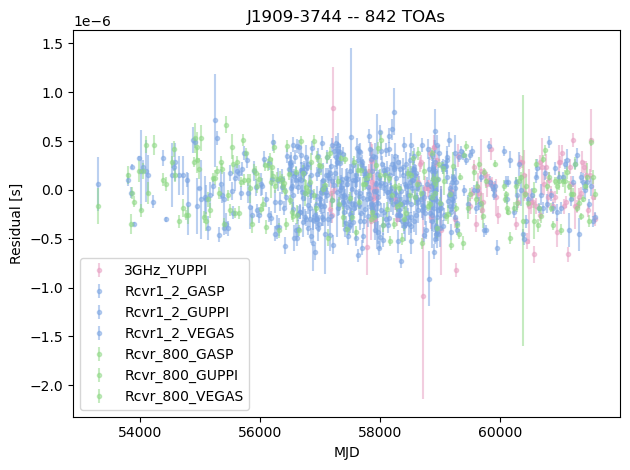

In [27]:
simulate.make_ideal(psr)

white_noise.add_measurement_noise(psr, efac=1, FACTOR=1)

for _ in range(3):
    psr.fit('gls')
    
# at this point, you could also inject in red noise and a GWB
savefilename = psr.name + '_residuals_without_factor.png'
make_residual_plot(psr,save=True, savefilename=savefilename)

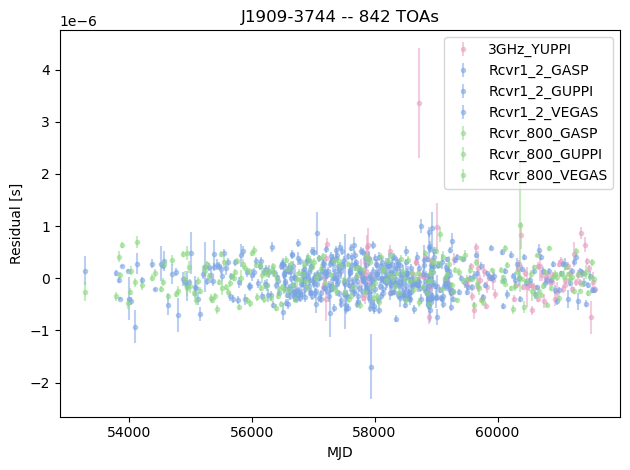

In [28]:
simulate.make_ideal(psr)

white_noise.add_measurement_noise(psr, efac=1, FACTOR=1.5420348502877987)

for _ in range(3):
    psr.fit('gls')
    
savefilename = psr.name + '_residuals_with_factor.png'
make_residual_plot(psr,save=True, savefilename=savefilename)

In [91]:
#use the noise dict from Nihan
#Nihan's noise dict for 15yr 
nihans_dict = '/Users/ashokan/osu/sarahspta/15yr_v1_fl_fwn_dict.json'
with open(nihans_dict,'r') as f:
    nihans_noise = json.load(f)

#NG20 real noise dict
ng20_noise_dict = '/Users/ashokan/osu/sarahspta/ng20_v1p1_dmx_noise_dict.json'
#from https://drive.google.com/drive/folders/1GQXnpyRglqPHwgQs6vE8VK-6VoL9WbSj
with open(ng20_noise_dict,'r') as f:
    ng20_noise_real = json.load(f)

#make a new noise dict with only chime and vegas pulsars
chime_vegas_noise_dict = {}
for k, v in ng20_noise_real.items():
    new_key = k.replace("t2equad", "equad")
    if "CHIME" in k or "YUPPI" in k or "VEGAS" in k or "J0125-2327" in k or "J0154+1833" in k or "J0614-3329" in k or "J0621+2514" in k or "J0732+2314" in k or "J0751+1807" in k or "J1022+1001" in k or "J1803+1358" in k or "J2022+2534" in k or "J2039-3616" in k or "J2150-0326" in k:
        print(k)
        chime_vegas_noise_dict[new_key] = v

#update nihans noise dict with chime and vegas pulsars from ng20
nihans_noise.update(chime_vegas_noise_dict)

B1855+09_CHIME_efac
B1855+09_CHIME_log10_ecorr
B1855+09_CHIME_log10_t2equad
B1855+09_Rcvr1_2_VEGAS_efac
B1855+09_Rcvr1_2_VEGAS_log10_ecorr
B1855+09_Rcvr1_2_VEGAS_log10_t2equad
B1937+21_3GHz_YUPPI_efac
B1937+21_3GHz_YUPPI_log10_ecorr
B1937+21_3GHz_YUPPI_log10_t2equad
B1937+21_CHIME_efac
B1937+21_CHIME_log10_ecorr
B1937+21_CHIME_log10_t2equad
B1937+21_Rcvr1_2_VEGAS_efac
B1937+21_Rcvr1_2_VEGAS_log10_ecorr
B1937+21_Rcvr1_2_VEGAS_log10_t2equad
B1937+21_Rcvr_800_VEGAS_efac
B1937+21_Rcvr_800_VEGAS_log10_ecorr
B1937+21_Rcvr_800_VEGAS_log10_t2equad
B1953+29_CHIME_efac
B1953+29_CHIME_log10_ecorr
B1953+29_CHIME_log10_t2equad
J0023+0923_CHIME_efac
J0023+0923_CHIME_log10_ecorr
J0023+0923_CHIME_log10_t2equad
J0023+0923_Rcvr1_2_VEGAS_efac
J0023+0923_Rcvr1_2_VEGAS_log10_ecorr
J0023+0923_Rcvr1_2_VEGAS_log10_t2equad
J0030+0451_CHIME_efac
J0030+0451_CHIME_log10_ecorr
J0030+0451_CHIME_log10_t2equad
J0030+0451_Rcvr1_2_VEGAS_efac
J0030+0451_Rcvr1_2_VEGAS_log10_ecorr
J0030+0451_Rcvr1_2_VEGAS_log10_t2equad
J0

In [92]:
nihans_noise["J0023+0923_CHIME_log10_ecorr"]
for k in nihans_noise.keys():
    if k.startswith("J1909-3744"):
        print(k)

J1909-3744_3GHz_YUPPI_efac
J1909-3744_3GHz_YUPPI_log10_ecorr
J1909-3744_3GHz_YUPPI_log10_equad
J1909-3744_Rcvr1_2_GASP_efac
J1909-3744_Rcvr1_2_GASP_log10_ecorr
J1909-3744_Rcvr1_2_GASP_log10_equad
J1909-3744_Rcvr1_2_GUPPI_efac
J1909-3744_Rcvr1_2_GUPPI_log10_ecorr
J1909-3744_Rcvr1_2_GUPPI_log10_equad
J1909-3744_Rcvr_800_GASP_efac
J1909-3744_Rcvr_800_GASP_log10_ecorr
J1909-3744_Rcvr_800_GASP_log10_equad
J1909-3744_Rcvr_800_GUPPI_efac
J1909-3744_Rcvr_800_GUPPI_log10_ecorr
J1909-3744_Rcvr_800_GUPPI_log10_equad
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A
J1909-3744_Rcvr1_2_VEGAS_efac
J1909-3744_Rcvr1_2_VEGAS_log10_ecorr
J1909-3744_Rcvr1_2_VEGAS_log10_equad
J1909-3744_Rcvr_800_VEGAS_efac
J1909-3744_Rcvr_800_VEGAS_log10_ecorr
J1909-3744_Rcvr_800_VEGAS_log10_equad


In [93]:
simulate.make_ideal(psr)

#white_noise.add_measurement_noise(psr, efac=1, FACTOR=1.5420348502877987)

#for _ in range(3):
#    psr.fit('gls')
    
#savefilename = psr.name + '_residuals_with_factor.png'
#make_residual_plot(psr,save=True, savefilename=savefilename)

In [94]:
for k in nihans_noise.keys():
    if k.startswith("J1909-3744"):
        print(k)

J1909-3744_3GHz_YUPPI_efac
J1909-3744_3GHz_YUPPI_log10_ecorr
J1909-3744_3GHz_YUPPI_log10_equad
J1909-3744_Rcvr1_2_GASP_efac
J1909-3744_Rcvr1_2_GASP_log10_ecorr
J1909-3744_Rcvr1_2_GASP_log10_equad
J1909-3744_Rcvr1_2_GUPPI_efac
J1909-3744_Rcvr1_2_GUPPI_log10_ecorr
J1909-3744_Rcvr1_2_GUPPI_log10_equad
J1909-3744_Rcvr_800_GASP_efac
J1909-3744_Rcvr_800_GASP_log10_ecorr
J1909-3744_Rcvr_800_GASP_log10_equad
J1909-3744_Rcvr_800_GUPPI_efac
J1909-3744_Rcvr_800_GUPPI_log10_ecorr
J1909-3744_Rcvr_800_GUPPI_log10_equad
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A
J1909-3744_Rcvr1_2_VEGAS_efac
J1909-3744_Rcvr1_2_VEGAS_log10_ecorr
J1909-3744_Rcvr1_2_VEGAS_log10_equad
J1909-3744_Rcvr_800_VEGAS_efac
J1909-3744_Rcvr_800_VEGAS_log10_ecorr
J1909-3744_Rcvr_800_VEGAS_log10_equad


In [95]:
for k in ng20_noise_real.keys():
    if k.startswith("J1909-3744"):
        print(k)



J1909-3744_3GHz_YUPPI_efac
J1909-3744_3GHz_YUPPI_log10_ecorr
J1909-3744_3GHz_YUPPI_log10_t2equad
J1909-3744_Rcvr1_2_GASP_efac
J1909-3744_Rcvr1_2_GASP_log10_ecorr
J1909-3744_Rcvr1_2_GASP_log10_t2equad
J1909-3744_Rcvr1_2_GUPPI_efac
J1909-3744_Rcvr1_2_GUPPI_log10_ecorr
J1909-3744_Rcvr1_2_GUPPI_log10_t2equad
J1909-3744_Rcvr1_2_VEGAS_efac
J1909-3744_Rcvr1_2_VEGAS_log10_ecorr
J1909-3744_Rcvr1_2_VEGAS_log10_t2equad
J1909-3744_Rcvr_800_GASP_efac
J1909-3744_Rcvr_800_GASP_log10_ecorr
J1909-3744_Rcvr_800_GASP_log10_t2equad
J1909-3744_Rcvr_800_GUPPI_efac
J1909-3744_Rcvr_800_GUPPI_log10_ecorr
J1909-3744_Rcvr_800_GUPPI_log10_t2equad
J1909-3744_Rcvr_800_VEGAS_efac
J1909-3744_Rcvr_800_VEGAS_log10_ecorr
J1909-3744_Rcvr_800_VEGAS_log10_t2equad
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A


In [96]:
def prepare_white_noise_inputs(psr_name, noise_dict):
    efacs = []
    log10_equads = []

    # iterate over all dict keys
    for key, value in noise_dict.items():
        if key.startswith(psr_name):
            if key.endswith("_efac"):
                efacs.append((key, float(value)))
            elif key.endswith("_log10_equad"):
                log10_equads.append((key, float(value)))

    # sort both lists by backend name to ensure matching order
    efacs.sort(key=lambda x: x[0])
    log10_equads.sort(key=lambda x: x[0])

    # convert to numpy arrays
    efacs_arr = np.array(efacs, dtype=object)
    log10_equads_arr = np.array(log10_equads, dtype=object)

    return efacs_arr, log10_equads_arr


In [97]:
efacs_arr, log10_equads_arr = prepare_white_noise_inputs(psr.name, nihans_noise)

In [98]:
efacs_arr

array([['J1909-3744_3GHz_YUPPI_efac', 1.0197055808778044],
       ['J1909-3744_Rcvr1_2_GASP_efac', 0.9618308530923484],
       ['J1909-3744_Rcvr1_2_GUPPI_efac', 1.0330610541401335],
       ['J1909-3744_Rcvr1_2_VEGAS_efac', 1.0354180154105217],
       ['J1909-3744_Rcvr_800_GASP_efac', 0.9925541208033604],
       ['J1909-3744_Rcvr_800_GUPPI_efac', 1.0291261563528888],
       ['J1909-3744_Rcvr_800_VEGAS_efac', 1.016525799378851]],
      dtype=object)

In [99]:
log10_equads_arr

array([['J1909-3744_3GHz_YUPPI_log10_equad', -7.6346927504308235],
       ['J1909-3744_Rcvr1_2_GASP_log10_equad', -7.296620295745842],
       ['J1909-3744_Rcvr1_2_GUPPI_log10_equad', -7.410868394338904],
       ['J1909-3744_Rcvr1_2_VEGAS_log10_equad', -7.694352272937432],
       ['J1909-3744_Rcvr_800_GASP_log10_equad', -6.7497781000219605],
       ['J1909-3744_Rcvr_800_GUPPI_log10_equad', -7.388409957191754],
       ['J1909-3744_Rcvr_800_VEGAS_log10_equad', -6.981745841144464]],
      dtype=object)

In [100]:
white_noise.add_measurement_noise(
    psr,
    efac = efacs_arr[:, 1].astype(float),
    log10_equad = log10_equads_arr[:, 1].astype(float),
    flagid = 'f',
    flags = efacs_arr[:, 0],
    seed = seed_efac_equad, FACTOR=1.8 
)

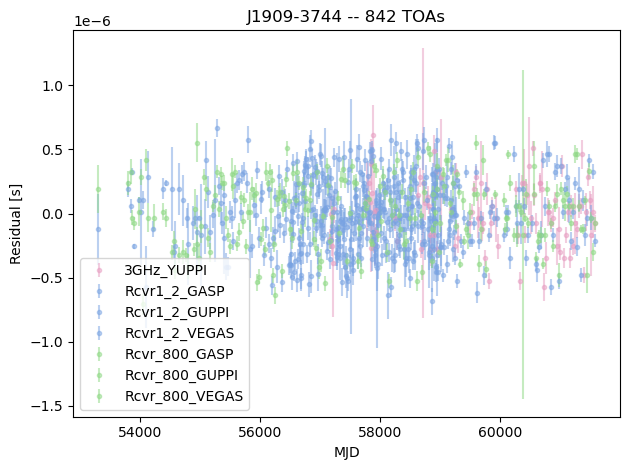

In [101]:
for _ in range(3):
   psr.fit('gls')
    
savefilename = psr.name + '_residuals_with_white_noise.png'
make_residual_plot(psr,save=True, savefilename=savefilename)